In [119]:
# __original_author__ =  'Humberto Brandão'
#__tweak__ = 'Team Monami'
import pandas as pd
import xgboost as xgb
import pickle as pkl
import numpy as np

# from matplotlib import pylab as plt
# import operator

# Load data and roughly clean it, then sort as game date
with open('df_test.pkl', 'rb') as f:
    df = pkl.load(f)
    
df = df[(df.prohibitBOBOption == False) | (df.prohibitBestOption == False)].copy()
# df.drop(['game_event_id', 'game_id', 'lat', 'lon', 'team_id', 'team_name'], axis=1, inplace=True)
# df.sort_values('game_date',  inplace=True)


In [132]:
# Clean data
# actiontypes = dict(df.action_type.value_counts())
# df['type'] = df.apply(lambda row: row['action_type'] if actiontypes[row['action_type']] > 25 else 'others', axis=1)
# df.drop(['action_type', 'combined_shot_type'], axis=1, inplace=True)

# df['away'] = df.matchup.str.contains('@')
# df.drop('matchup', axis=1, inplace=True)

# df['distance'] = df.apply(lambda row: row['shot_distance'] if row['shot_distance'] <45 else 45, axis=1)
# df['time_remaining'] = df.apply(lambda row: row['minutes_remaining'] * 60 + row['seconds_remaining'], axis=1)
# df['last_moments'] = df.apply(lambda row: 1 if row['time_remaining'] < 3 else 0, axis=1)

# data = pd.get_dummies(df['type'],prefix="action_type")

# features=["away", "period", "playoffs", "shot_type", "shot_zone_area", "shot_zone_basic", "season",
#            "shot_zone_range", "opponent", "last_moments"]
# for f in features:
#     data = pd.concat([data, pd.get_dummies(df[f], prefix=f),], axis=1)
# data = pd.concat([data, df['distance'],], axis=1)

features = ['normalPostCount', 'bestPostCount', 'BOBPostCount', 

            'imgCount', 'youtubeCount', 'videoCount', 
            'writerVisitingCount', 'textLineCount',
            'humordata','freeboard','love','star','sisa',
            'okIn900s', 'memoIn900s',]
features += ['morning', 'noon', 'evening', 'night']

data = df[features].copy()

# data = data[features].copy()
mask = np.random.rand(len(data)) < 0.1 #mask for training set
data.rename(columns=lambda x: x.replace(" ",""),inplace=True)

X = data[~mask]
y = df.isBOB[~mask]
# y = df.viewCount[~mask]
# data = data.loc[:,~df.columns.duplicated()]
dtrain=xgb.DMatrix(data=X, label=y, missing =None)

In [124]:
df[df.isBOB == 0].index



Index(['bestofbest_227818', 'bestofbest_227835', 'bestofbest_229558',
       'bestofbest_229906', 'bestofbest_231650', 'bestofbest_231990',
       'bestofbest_232015', 'bestofbest_232213', 'bestofbest_232585',
       'bestofbest_232674',
       ...
       'humordata_1526435', 'humordata_1682388', 'humordata_1554598',
       'humordata_1493780', 'humordata_1585617', 'humordata_1610186',
       'humordata_1657168', 'humordata_1620251', 'humordata_1570594',
       'humordata_1491651'],
      dtype='object', name='contentID', length=40778)

In [133]:
param ={   'objective'                : "binary:logistic",
                'booster'             : "gbtree",
                'eval_metric'         : "logloss",
                'eta'                 : 0.042,
                'max_depth'           : 10,
                'subsample'           : 0.82,
                'colsample_bytree'    : 0.60,
                'seed'                : 1,
                'silent'              : 0
}
clf = xgb.cv(   params                = param,
                dtrain                = dtrain,
                num_boost_round       = 1000,
                maximize              = False,
                nfold                 = 5,
                early_stopping_rounds = 20
);
print(clf[[0]].min(0))
bestround = clf[[0]].idxmin(0)[0]

test-logloss-mean    0.278645
dtype: float64


In [134]:
# param ={   'objective'                : "reg:linear",
#                 'booster'             : "gbtree",
#                 'eval_metric'         : "rmse",
#                 'eta'                 : 0.012,
#                 'max_depth'           : 10,
#                 'subsample'           : 0.82,
#                 'colsample_bytree'    : 0.60,
#                 'seed'                : 1,
#                 'silent'              : 0
# }
# clf = xgb.cv(   params               = param,
#                 dtrain                      = dtrain,
#                 num_boost_round    = 1000,
#                 maximize                 = False,
#                 nfold                       = 5,
#                 early_stopping_rounds  = 20
# );
# print(clf[[0]].min(0))
# bestround = clf[[0]].idxmin(0)[0]

In [135]:
bst = xgb.train(  params                    = param,
                        dtrain                       = dtrain,
                        num_boost_round     = bestround,
                        verbose_eval            = 1,
                        maximize                  = False
)

In [136]:
test_X = data[mask]
test_y = df[mask]["isBOB"]
dtest =xgb.DMatrix(data=test_X, missing =None)
preds = bst.predict(dtest)
# submission = pd.DataFrame({"shot_id": target_id, "shot_made_flag": preds})
# submission = submission.sort_values('shot_id')
# submission.to_csv("submit_xgboost_ref.csv", index=False)

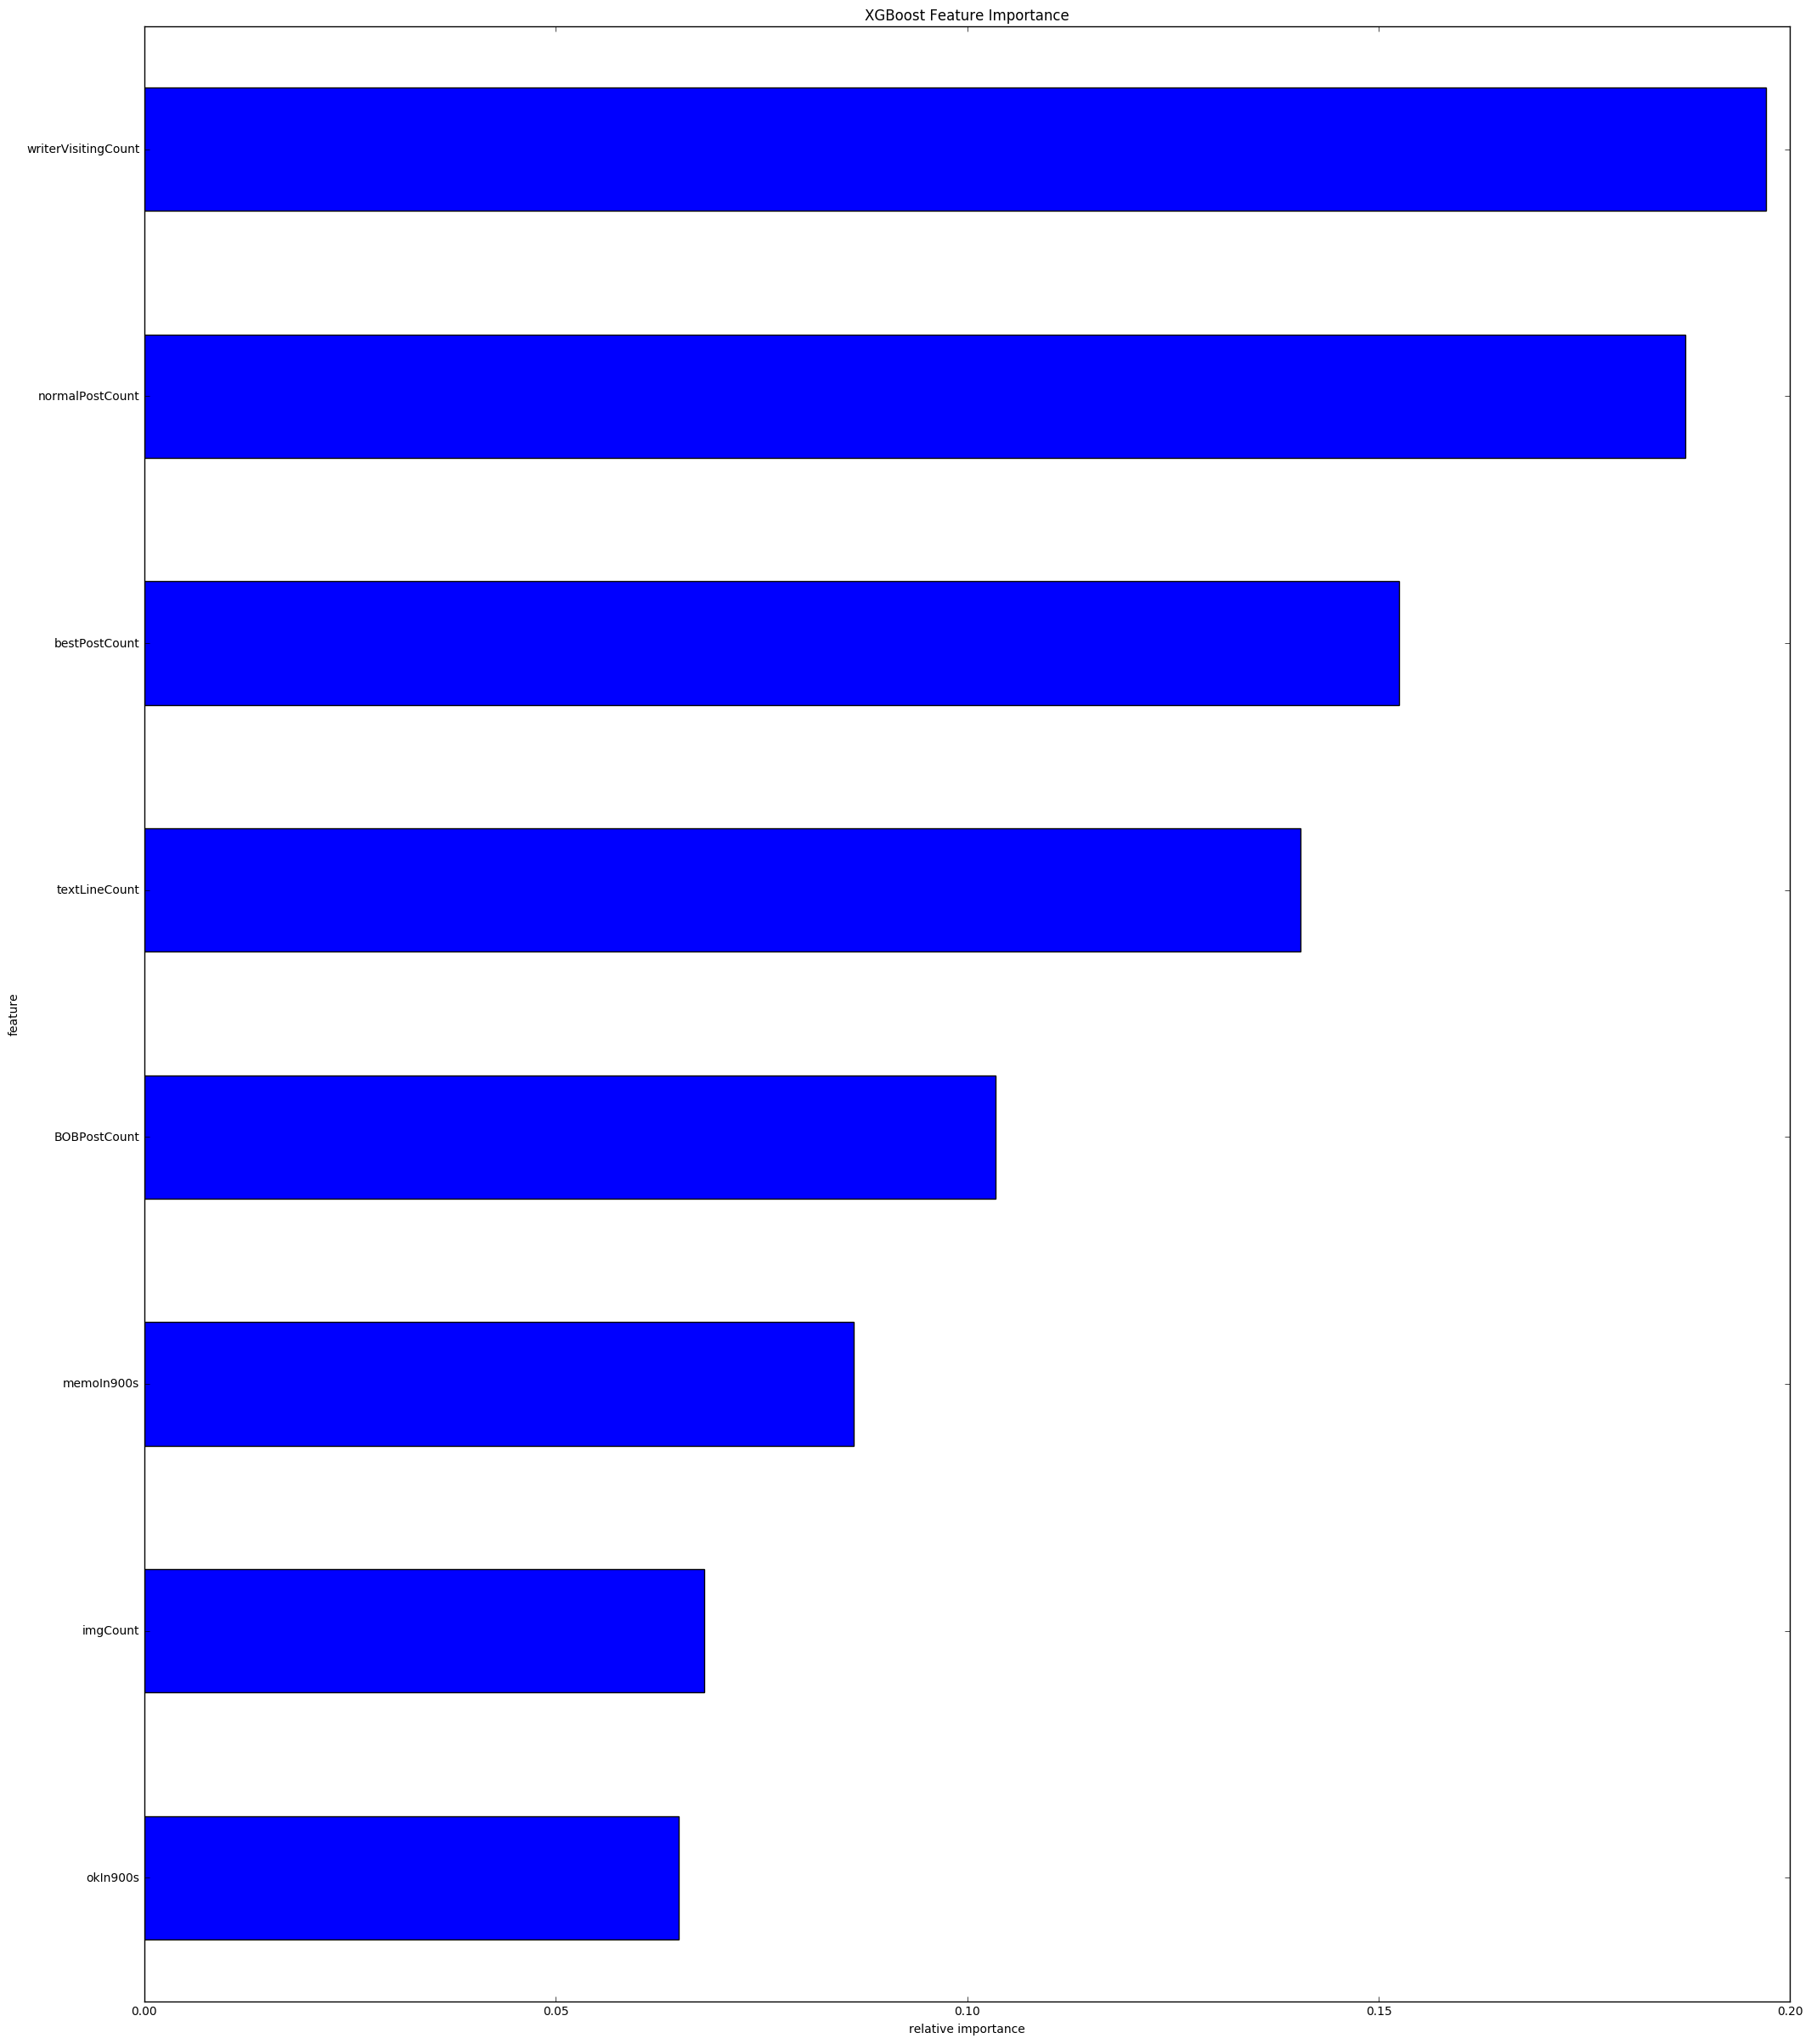

In [139]:
import  operator
import matplotlib.pyplot as plt
%matplotlib inline  

def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

ceate_feature_map(list(X.columns))
ceate_feature_map(features)
importance = bst.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))[-8:]

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
# df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(25, 30))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [140]:
df['fscore']

0    0.064925
1    0.068068
2    0.086249
3    0.103414
4    0.140467
5    0.152475
6    0.187287
7    0.197114
Name: fscore, dtype: float64

In [141]:
importance

[('okIn900s', 8635),
 ('imgCount', 9053),
 ('memoIn900s', 11471),
 ('BOBPostCount', 13754),
 ('textLineCount', 18682),
 ('bestPostCount', 20279),
 ('normalPostCount', 24909),
 ('writerVisitingCount', 26216)]

In [152]:
people = [key[0] for key in importance]
people

['okIn900s',
 'imgCount',
 'memoIn900s',
 'BOBPostCount',
 'textLineCount',
 'bestPostCount',
 'normalPostCount',
 'writerVisitingCount']

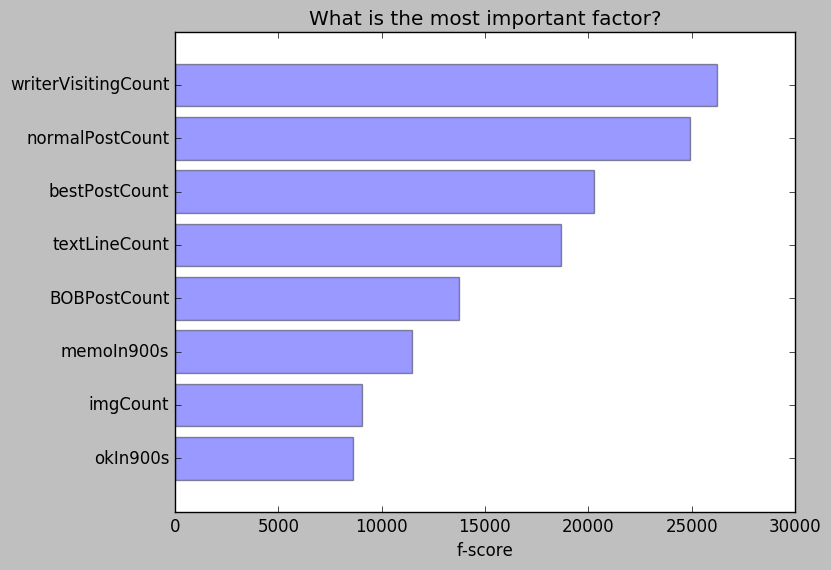

In [153]:
import matplotlib.pyplot as plt
plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


# Example data
people = [key[0] for key in importance]
y_pos = np.arange(len(people))
performance = [key[1] for key in importance]

plt.barh(y_pos, performance, align='center', alpha=0.4)
plt.yticks(y_pos, people)
plt.xlabel('f-score')
plt.title('What is the most important factor?')

plt.show()

Thus in binary classification, the count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.


In [106]:
from  sklearn.metrics import confusion_matrix
p = confusion_matrix(test_y.values, preds > 0.8)

In [107]:
print("xgboost precision: {}".format(p[1][1]/(p[0][1]+p[1][1])))
print("xgboost recall: {}".format(p[1][1]/(p[1][1] + p[1][0])))

 

xgboost precision: 0.9329173166926678
xgboost recall: 0.7295224817009411


In [54]:
p

array([[7170,  921],
       [ 358, 1807]])

array([[6788,  338],
       [ 900, 1127]])

In [108]:
########  SVM
from sklearn import svm
clf = svm.SVC()

clf.fit(X,y)

score = clf.score(test_X,test_y)
y_predict = clf.predict(test_X)
y_All_no = np.zeros(len(test_y))
h = confusion_matrix(test_y, y_predict)
#df_all_new = pd.concat([df_all,df_all_timeZone], axis = 1)

In [109]:
print("svm precision: {}".format(h[1][1]/(h[0][1]+h[1][1])))
print("svm recall: {}".format(h[1][1]/(h[1][1] + h[1][0])))

svm precision: 0.7635810517166449
svm recall: 0.9186127570582084


In [30]:
from scipy.stats.stats import spearmanr
for feature in :
    df.recommendCount
    

array([0, 0, 1, ..., 0, 1, 0])

In [47]:
h

array([[7787,  304],
       [1244,  921]])